# Hello World of Neural Networks - MNIST handwritten digits

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify hand-written digits. The dataset we will use is the MNIST handwritten digit classification, a classic dataset in the deep learning community. You can think of "solving" MNIST as the "Hello World" of deep learning programs for computer vision.

Each image in the MNIST dataset is 28x28 and contains a centered, grayscale digit. We’ll flatten each 28x28 into a 784 dimensional vector, which we’ll use as input to our neural network. Our output will be one of 10 possible categories (0 to 9).

<img src="./resources/mnist-examples.png"  style="height: 315px"/>


Before we get started, a side note: it might be a very good idea, to create a new DL_env virtual environment, if you haven't done so already. Because in deep learning we'll need a lot of different libraries, and some will conflict with the general ML libraries. 

In [1]:
pip install matplotlib numpy pandas scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/59/ed/548f6f686845d386a727a51a3daa411d95fc599649a2d54705f6773ac259/scikit_learn-1.3.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/3a/98/3041681b3a0fef0f59033861a05d846aa1d284b07b531ce35b1b97cc2e93/scipy-1.11.3-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 3.1 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metad

## 1. Import packages and classes

We'll use tf.keras, a high-level API to build and train models in TensorFlow. If you ever need more info on a certain function, have a look at their awesome documentation! https://keras.io/api/


In [2]:
pip install tensorflow keras mnist

Note: you may need to restart the kernel to use updated packages.


In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(tf.__version__)

2.14.0


## 2. Import the MNIST dataset

The MNIST dataset is relatively small, and is often used as a kind of benchmark to verify that an algorithm works as expected. 

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the MNIST directly from TensorFlow, just import and load the data.

In [12]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Note: the validation data will be selected when we fit our training data to our model (see below: '7. Train the model').

## 3. Explore the data (EDA)

Let's explore the format (shape and size) of the dataset before training the model. 

In [13]:
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


This shows that you have 60,000 images of size 28 by 28 pixels for training, and 10,000 images of the same size for testing. These are gray scaled images, since there is no mention of multiple color channels. If you would have loaded color images, you would see a shape like: (60000, 28, 28, 3), where the 3 stands for the 3 color channels, RGB. 

You also have 60,000 labels for training and 10,000 labels for testing. 

Next up: checking what kind of labels do we have, and how many. So, let's check the distribution of our data: which classes (or different labels) are there, and how many of each class, so we can check if there is any major inbalance in our data we should be aware of.

In [14]:
unique_y_train, counts_y_train = np.unique(y_train, return_counts=True)
unique_y_test, counts_y_test = np.unique(y_test, return_counts=True)
print("Unique train labels:", unique_y_train)
print("Counts train labels:", counts_y_train)
print("Unique test labels:", unique_y_test)
print("Counts test labels:", counts_y_test)

Unique train labels: [0 1 2 3 4 5 6 7 8 9]
Counts train labels: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Unique test labels: [0 1 2 3 4 5 6 7 8 9]
Counts test labels: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


Quick printout of the first and the last 10 labels of both sets, so we can check if they are ordered (sorted), or shuffled. 

In [15]:
print("The first 10 labels in the training set:", y_train[:10])
print("The last 10 labels in the training set:", y_train[-10:])
print("The first 10 labels in the test set:", y_test[:10])
print("The last 10 labels in the test set:", y_test[-10:])

The first 10 labels in the training set: [5 0 4 1 9 2 1 3 1 4]
The last 10 labels in the training set: [9 2 9 5 1 8 3 5 6 8]
The first 10 labels in the test set: [7 2 1 0 4 1 4 9 5 9]
The last 10 labels in the test set: [7 8 9 0 1 2 3 4 5 6]


For a visual inspection of the counts, let's create a subplot with 1 row and 2 columns: column 1 for the training data, and column 2 for the test data:

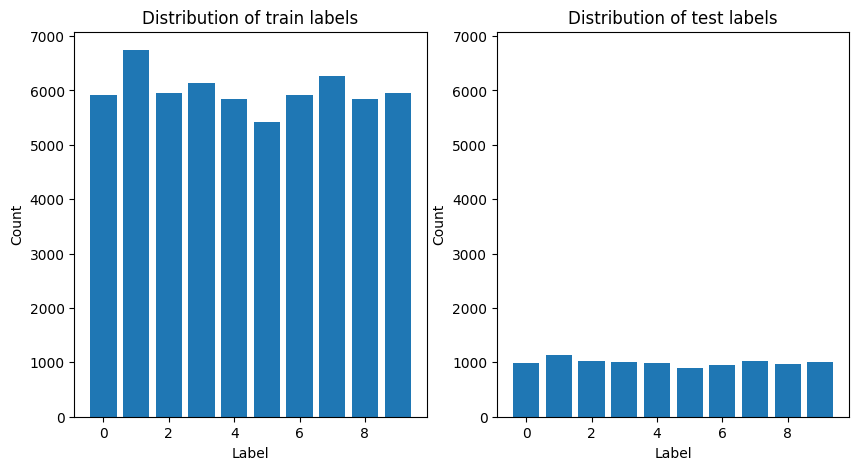

In [16]:
plt.figure(figsize=(10, 5))

# Create a subplot for the train labels
plt.subplot(1, 2, 1)
# Create a barchart for the train labels
plt.bar(unique_y_train, counts_y_train)
# Set the title and labels of the plot
plt.title("Distribution of train labels")
plt.xlabel("Label")
plt.ylabel("Count")
# Get the y-axis limits of the first subplot, so I can apply them to the second plot as well, for a decent comparison
ymin, ymax = plt.ylim()

# Create a subplot for the test labels
plt.subplot(1, 2, 2)
# Create a barchart for the test labels
plt.bar(unique_y_test, counts_y_test)
# Set the title and labels of the plot
plt.title("Distribution of test labels")
plt.xlabel("Label")
plt.ylabel("Count")
# Set the same y-axis limits as the first subplot
plt.ylim([ymin, ymax])

# Show the plot
plt.show()



And finally, let's take a quick peek at the training and test data itself. 

First, let's do a printout of one image, so we can get a sense of how it looks like in raw data format (for visualizing we put the numpy matrix into a panda DataFrame, so it looks a little better). 

And after we had a look at the raw data, let's visualize some of the images.

In [17]:
import pandas as pd
df = pd.DataFrame(X_train[0])
df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


So, we can see each row in the image is 28 pixels long, and we have 28 rows. Each pixel has a value between 0 and 255. This is important to know, so we can do some preprocessing later on. And we can already kind of see the pattern of the number '5' in the raw data.
But, let's draw it, and a couple more for the train and the test set as images, just to be sure:

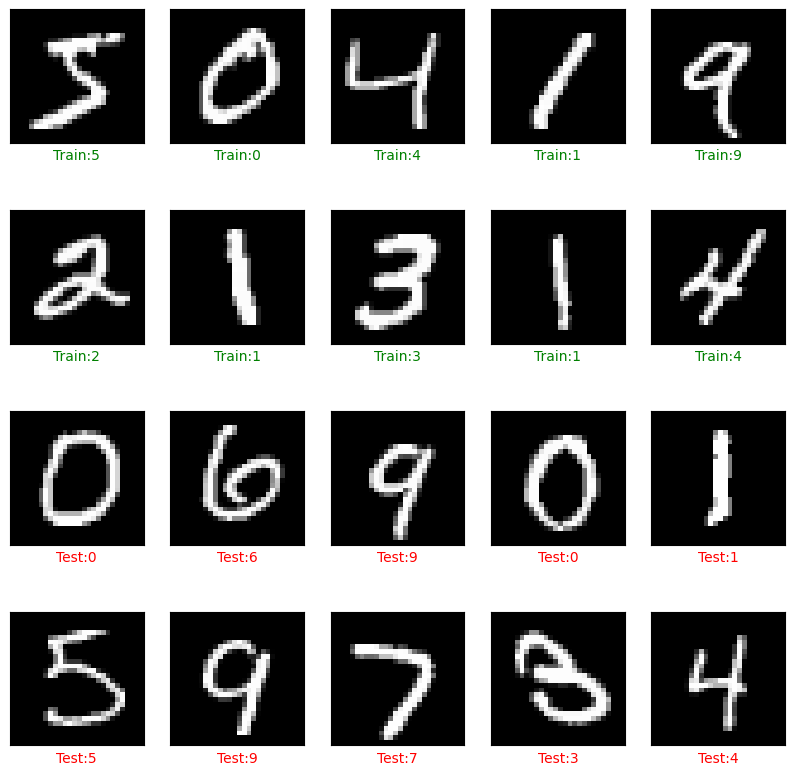

In [18]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1) # 4 rows, 5 columns, cellnumber
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if i < 10:
        plt.imshow(X_train[i], cmap='gray') # if you want them in inverted colors: ax.imshow(X_train[i], cmap='binary'))
        label = plt.xlabel("Train:"+ str(y_train[i])).set_color("green")
    else:
        plt.imshow(X_test[i], cmap='gray')
        label = plt.xlabel("Test:"+ str(y_test[i])).set_color("red")
plt.show()

## 4. Preprocess the data & Build the model

As we could notice in our previous section, our input data, the pixels, are all in the range [0, 255], yet we know that our neuron activations should be in the range between [0, 1] for optimal performance. So, it's best to normalize or standardize our input pixel data to that range of [0, 1] as well. 

To do this, we can simply divide the values by 255. This will give us the range of 0 to 1. There are other, more mathematical ways to normalize data, but this simple normalization is just fine when dealing with images and pixels. 

**It's important to note that all data (the train set, the test set, other images we want to send to our model) must always be preprocessed in the same way.** 

We could do it manually (for instance: X_train = X_train / 255.0), but it's best practise to **include the preprocessing inside the model structure**. This way, we can send our unprocessed data to it, and everything is handled by the model. Even when we save the entire model, the correct preprocessing is saved with it!

**Defining the model**

The basic building block of creating a neural network in Keras, is a **layer**. Most of deep learning, consists of chaining together simple layers in a certain way. For now, we'll chain our layers together in a **sequential** nature (layer behind layer behind layer), as opposed to for instance a recurrent nature, where we have feedback loops.

First, let's define our model. And give the description of each layer below.

In [19]:
model = keras.Sequential([
    # Preprocessing: Add a Rescaling layer to rescale the pixel values to the [0, 1] range
    layers.Rescaling(1./255),
    # Input Layer: Add a Flattening layer to make 1-D vector of our 28x28 images
    layers.Flatten(input_shape=(28, 28)),
    # Hidden layer: Add a Dense layer, aka a fully or densely connected layer of 128 neurons, and let them use the 'ReLu'-squishing or activation function
    layers.Dense(128, activation='relu'),
    # Output layer: Add a Dense layer of 10 neurons (because we have 10 possible output labels), and link those neurons together in a group, via the 'softmax'-activation function
    layers.Dense(10, activation='softmax')
])

- Preprocessing layer: add a `layers.Rescaling` to make sure all pixel values have a [0, 1]-range
- Input Layer: add a `layers.Flatten`, which transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. Think of this layer as unstacking rows of pixels in the image, and lining them up. Each pixel is now an input for our neural network
- Hidden Layer: Add a `layers.Dense` layer of 128 neurons. This is a densely-connected, or fully-connected, neural layer.The second layer has 128 nodes (or neurons) and uses the **ReLU activation** function. The ReLu is another activation function we could use in the hidden layers.
- Output layer: Add a `layers.Dense` layer of 10-neurons using the **softmax activation**. The softmax is the 3rd activation function we encounter, and can only be used in the output layer. It links all those output neurons together into one group, so it can return an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image corresponds to that perticular the digit.

## 5. Recap Activation functions

Activation functions are squishing functions, that take the weighted sum of the incoming connections, and squeezes (or transforms) the output into the [0, 1]-range. In this intro AI course, we'll be using 3 possible activation functions:

- **Sigmoid**: S-shape activation function, been around a long time. Has some drawbacks when used in deep networks (out of scope, vanishing gradient problem). Mainly used in **hidden layers**, but can also be used in the output layer, mainly when you have one output (or multiple unlinked outputs)
- **ReLu**: newer version of the sigmoid. Fixes some of the drawbacks that the sigmoid had. Only used in **hidden layers** to try to find features in the data

Which activation function to choose in the hidden layers? Like the number of neurons, or the number of hidden layers: it's a design choice. There is no fixed rule. It usually comes down to trial & error, experience,... when you manually want to create a network.


- **Softmax**: like the sigmoid, but only used in the **output layer**, when we want to link the output neurons together into one group, and we want a clear winner out of that group (it gently pushes the winner to a higher probability number, and downplays lesser import ones - hence: 'soft-max')

## 6. Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function** — This measures how accurate the model is during training. We want to minimize this loss, or error function to "steer" the model in the right direction. Since we're doing classification, we need some kind of measurement of how clean, how pure, how 'chaotic' our predictions are. That's why we use an entropy based measurement. 

Note: we can use sparse categorical crossentropy or categorical crossentropy. Both work the same, but it all depends on how our label is encoded. In this example our label is encoded with an integer between 0 and 9, and we have to map this number against our 10 different output neurons. Here we'll use the `sparse categorical crossentropy`, because our label is sparse-ly encoded. Our label could also be one-hot encoded. For example, a 0 = 0000000001, 1 = 0000000010, 2 = 0000000100,  3 = 0000001000, etc. This is easier to map to our output neurons. When we used that kind of encoding, than we should use the `categorical crossentropy`.

- **Optimizer** — This is how the model is updated based on the data it sees, and its loss function. We'll stick with a pretty good default: the Adam-gradient-descend-based optimizer. As we discussed in the previous notebook. An optimizer also needs a learning rate, because Adam only gives us a direction on how to update our weights, not by how much. If you give no learning rate, the default of 0.001 is used. Tweaking, using a learning rate schedule, or searching for an optimal learning rate, is sometimes considered one of the most important part of training a neural network. But for now, let's just stick with the default.

Designing and training a neural network effectively is sometimes considered more like an artform: choosing which architecture, how many layers, how many neurons, which activations, which loss function, which optimizer, which learning rate,... We'll get around this obstacle, when we tackle the concept of transfer learning...

- **Metrics** — Used to monitor the training and testing steps. Since this is a classification problem, we'll just have Keras report on the accuracy metric.

In [20]:
# Compile the model with the optimizer, loss, and metrics
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 7. Train the model

Training a model in Keras literally consists only of calling `fit()` and specifying the training parameters. There are a lot of possible parameters (check: https://keras.io/api/models/model_training_apis/), but we'll only manually supply a few :

- The training data (images and labels), commonly known as **X** and **y**, respectively.
- The number of **epochs** (iterations over the entire dataset) to train for. How many times to we run all our training data through our network, since it's an iterative learner.
- The **batch size**: we could run image by image through our network, and update the weights each image. But usually, we send a couple of images, a batch, through our network all at once, and calculate the updates for our weights for this entire batch all at once (did someone say 'parallelization'?). 
    - Again, choosing a batch size is more trial and error, and expertise. Not a fixed rule. If your RAM is big enough, you can send a lot more images all at once through, and training would be faster. But, sometimes, suboptimal. On the other hand, if you do it one by one, it takes a really long time... 
    - In our example below, we'll use a batch size of 50 images. For training we use 60k images, but 20% is validation. So 80% of 60k=48k. And a batch of 50 --> 960 batches needed to run through entire training set. 
- The **validation split**: we want 20% of our training data to be randomly selected as validation data. 

Remember: neural networks are iterative learners. So, we need to know when we are overfitting on our training data. But, we can't use the test data, because those datapoints have to be used to evaluate how good our model really is, after we've done tweaking and training. We need something similar like the test set, but one that can be used during training and tweaking of our model. This is the validation set. Is a (random) part of the training set, that's used to check how well we are doing, during training and tweaking. We tweak and adjust our weights and biases on the training data, check how well we are doing on the validation data, tweak some more on the training data, check with the validation data, etc. Until we are satisfied with the performance. 

And only after all tweaking and training is done, and we're pretty confident that our model will perform well, will we use the test set to check how well our model will do on data it has never ever seen before. A true performance evaluation...

The training process is also saved in a **history object**, so we can visualize our training process. (Note: we can only visualize after training is completed. It's not a live tracking...)

In [21]:
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20
960/960 [==============================] - 4s 3ms/step - loss: 0.3139 - accuracy: 0.9130 - val_loss: 0.1747 - val_accuracy: 0.9498
Epoch 2/20
960/960 [==============================] - 3s 3ms/step - loss: 0.1408 - accuracy: 0.9586 - val_loss: 0.1267 - val_accuracy: 0.9617
Epoch 3/20
960/960 [==============================] - 3s 3ms/step - loss: 0.0974 - accuracy: 0.9714 - val_loss: 0.1037 - val_accuracy: 0.9687
Epoch 4/20
960/960 [==============================] - 3s 3ms/step - loss: 0.0730 - accuracy: 0.9788 - val_loss: 0.1007 - val_accuracy: 0.9691
Epoch 5/20
960/960 [==============================] - 3s 3ms/step - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0898 - val_accuracy: 0.9731
Epoch 6/20
960/960 [==============================] - 3s 3ms/step - loss: 0.0453 - accuracy: 0.9865 - val_loss: 0.0868 - val_accuracy: 0.9740
Epoch 7/20
960/960 [==============================] - 3s 3ms/step - loss: 0.0355 - accuracy: 0.9897 - val_loss: 0.0841 - val_accuracy: 0.9750
Epoch 

As the model trains, the loss and accuracy metrics are displayed. This model reaches an **accuracy (how many images are correctly classified)** of about 0.998 (or 99.8%) on the training data. This doesn’t tell us much, though - we may be overfitting. 

To check for overfitting, we have to plot the training and validation **loss (our entropy chaos measurement to optimize our settings during training)** next to eachother. During training, the training loss should keep getting smaller and smaller, since we're optimizing our weights & biases to do just that. Sometimes, it could be that the training loss goes up and down, or doesn't really pick up. This means that our training isn't going that great, and usually has to do with the learning rate, or the model design-choices (it's more of an art-form, remember?).

But the main thing: are we overfitting? To check this, we plot the validation loss in the same graph as the training loss. We would normally expect the validation loss to also keep going down, since the network is picking up on patterns in the training data, and those patterns should also be present in the validation data. But, at a certain moment, our network will start to focus too much on very specific patterns in the training data, like memorizing those exact patterns. Since those patterns aren't present in the validation data, the validation error should go up. At this point, our model is starting to overfit.

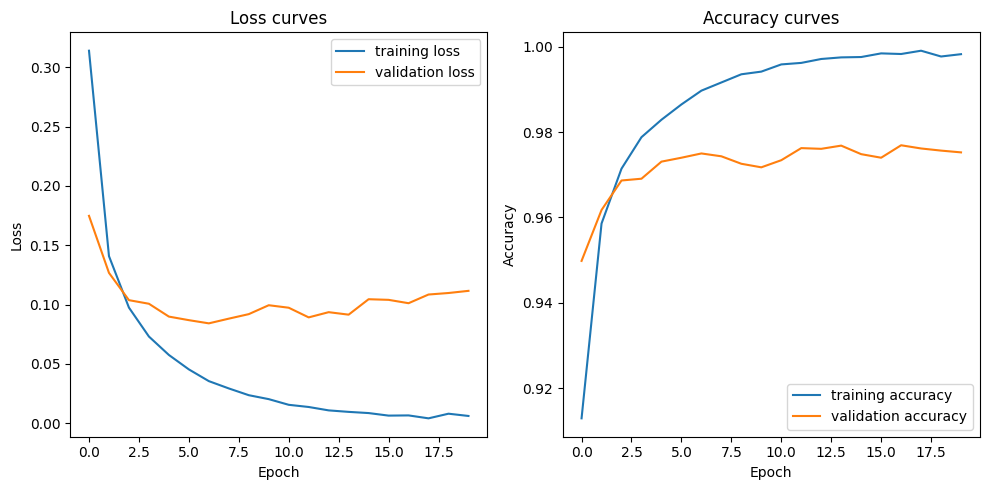

In [22]:
# Create a figure and a grid of subplots with a single call
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the loss curves on the first subplot
ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves on the second subplot
ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()


As you can see in the images above, around epoch 5, our validation loss has the tendency to start rising (validation loss has a rising trend versus the declining trend of the training loss = overfitting). 

Also, the gap between the validation loss and the training loss keeps getting bigger. This gap is also called the generalization gap. Our network focusses a lot harder on the aspects that are in the training set, but it only has a marginal benefit for data in the validation set ('unseen data for training').

So, we've should have probably stopped around 5 epochs, in this example.

## 8. Evaluate accuracy on test set

The proof of the pudding, is in the eating. So, now it's finally time to evaluate our model on never seen before data. Luckily, our test data has labels as well. So we can let our model do a prediction on the test data, compare those predictions to the true label of the set to get a confusion matrix (like we covered in the Machine Learning part), and to wrap things up: do a general evaluation of the results, based on accuracy (% of images classified correctly).  

Remember: when we are doing classification, accuracy doesn't tell the whole story. A more nuanced view, can be reached by using a confusion matrix. 

313/313 [==============================] - 1s 2ms/step
The probabilities: 
[1.12887434e-11 1.07955806e-13 6.39819239e-11 2.66931283e-06
 4.75570495e-18 1.53860401e-14 1.24424901e-18 9.99997377e-01
 5.17463919e-11 1.22685666e-08]

The highest probability, is the number: 7


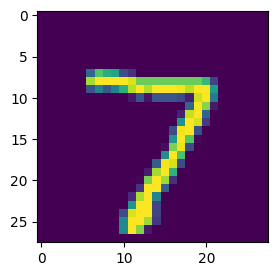

In [23]:
# Generate predictions for all the test images
predictions = model.predict(X_test)

# Take a look at the prediction of the first test image
print("The probabilities: \n"+str(predictions[0])+"\n")
# Only printout the one with the highest probability, the winner, the one our network this it is
print("The highest probability, is the number: "+str(np.argmax(predictions[0])))

# Plotting the first test image to check our prediction
plt.figure(figsize=(3,3))
plt.imshow(X_test[0])
plt.grid(False)
plt.show()

Looks pretty good so far, just by checking the first test image. 

Now let's create the confusion matrix, so we can get a better view on the quality of our predictions, over the entire test set.

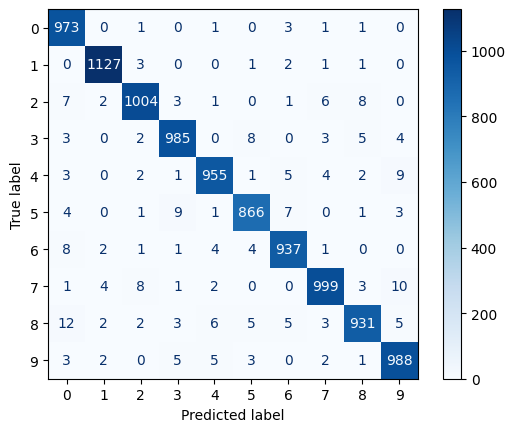

In [26]:
# First, let's transform all the prediction into the winners (otherwise each prediction gives us the 10 probabilities, but we only need the winner, the one our network thinks it is)
pred = np.argmax(predictions, axis=1)
# Now, compare the true labels of the test set, to our predicted winners
cm = confusion_matrix(y_test, pred)
# print(cm)

# Make the confusion matrix a little more visually attractive
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

And finally, to get a nice summarized number for how good our model actually is on the test set, let's get the final accuracy over the entire test set:

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1057 - accuracy: 0.9765
Test accuracy: 0.9764999747276306


## 9. Saving the Model

Now that we have a working, trained model, we’ll save it to disk so we can load it back up anytime.

The preferred way, is to save the entire model (architecture, optimizer state, and weights) all at once. This way we benefit the most of including our preprocessing layers inside our model (see step 4).
We could also only save the weights, but then we have to remember our exact architecture and preprocessing that we used, when we want to use our model in another application.

In [28]:
# save entire model: either in the native keras format .keras, or the tensorflow format .tf, or the lagacy format .h5

# model.save("saved_models/my_mnist.keras")
model.save("saved_models/my_mnist.tf")
# model.save("saved_models/my_mnist.h5")

INFO:tensorflow:Assets written to: saved_models/my_mnist.tf\assets


INFO:tensorflow:Assets written to: saved_models/my_mnist.tf\assets


We can now reload the trained model whenever we want, and we don't even have to rebuilding it. We could even train it some more epochs if we want to.

In [29]:
# load the model's saved weights
new_model = load_model("saved_models/my_mnist.tf")

test_loss, test_acc = new_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1057 - accuracy: 0.9765
Test accuracy: 0.9764999747276306


See: the new_model is exactly the same model as our original trained model.

## 10. Exercise - Sanity Check

First, let's draw the first 20 __test images__ (5 images in a row), and below the image print the actual digit (a) and the predicted digit (p). If they are the same, the textcolor is green, red otherwise. You should get something like this:

<img src="./resources/digits.png"/>

Since we achieved a pretty high accuracy, most of the labels should be green. This is a very need thing to have, since it's a good visual sanity check!

In [ ]:
# Sanity check code goes here

# 11. Exercise - Most Confused

Maybe even better, is a piece of code where we can plot those images our model was most confused about. To do this, we first have to find all our wrongly predicted images from the test set. Next, we should get for all those wrongly predicted images their respective prediction, the actual label, and the prediction probability.

As a final piece, we could sort those wrongly predicted images by their prediction probability, so the ones that where predicted very confidently (almost 0.9999% sure), are at the very top of our list. Then we only need to visualize those images with their predicted and actual label to get a visual confirmation why it was so hard for our model to classify that image correctly.

This is really useful in practise, since this allows us to visually check where our model went completely wrong. But maybe, their was a wrongly labelled image in our dataset? Well, this piece of code should help detect those kinds of problems...

In [ ]:
# Find all wrong predictions from test set

# Create a list of tuples, containing the index, the prediction, the prediction probability, and the corresponding test label

# Sort the list by prediction probability, descending order

# Visualizing the top 3 most wrong predictions